# **EEG-based Research on Social-Emotional Learning (SEL)**

# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import sklearn
from sklearn.impute import KNNImputer
from scipy.stats import norm, skew
from scipy.signal import butter, filtfilt, medfilt
from scipy.signal import find_peaks
import seaborn as sns
import copy
import math
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report, ConfusionMatrixDisplay,f1_score
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
import time
import warnings
from sklearn.exceptions import FitFailedWarning
from sklearn.svm import SVC
from sklearn import svm

# Loading Data

##Importing dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Mind Monitor Version

In [ ]:
filepath = '/content/drive/MyDrive/SRIP Project 8/EEG Data/18 June/Activity 3 Cartesian Skeptic Headset 3 (18 June).csv'
df = pd.read_csv(filepath, skiprows=0)#df = df.dropna()
#data = df.to_numpy()

# Load the data (assuming 'df' is your DataFrame)
#data = df

# Normalize timestamps to start from 0
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'], format='%Y-%m-%d %H:%M:%S.%f')
df['TimeStamp'] = (df['TimeStamp'] - df['TimeStamp'].iloc[0]).dt.total_seconds()
df = df[['TimeStamp', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10']]
df = df.rename(columns={'TimeStamp': 'timestamps', 'RAW_TP9': 'TP9', 'RAW_AF7' : 'AF7', "RAW_AF8" : 'AF8', 'RAW_TP10' : 'TP10'})

data = df.to_numpy()
data = df.dropna()
data

,timestamps,TP9,AF7,AF8,TP10
1,0.040,813.113553,736.153846,769.597070,788.534799
2,0.041,825.604396,744.615385,769.194139,794.578755
3,0.041,824.798535,760.732601,776.446886,813.113553
4,0.041,834.065934,769.194139,776.043956,828.827839
5,0.041,849.377289,761.135531,764.358974,822.783883
...,...,...,...,...,...
123496,478.631,840.109890,753.479853,885.238095,840.109890
123497,478.631,841.721612,729.706960,887.655678,868.717949
123498,478.631,827.216117,730.915751,863.882784,854.212454
123499,478.632,836.080586,761.941392,820.769231,828.424908


Powershell Version

In [ ]:
filepath = '/content/drive/MyDrive/SRIP Project 8/EEG Data/4 July/Activity 3 Crossword Headset 2 (4 July).csv'
df = pd.read_csv(filepath, skiprows=0)
data = df.to_numpy()
df

# Load the data (assuming 'df' is your DataFrame)
data = df

# Normalize timestamps to start from 0
data['timestamps'] -= data['timestamps'].iloc[0]

data

,timestamps,TP9,AF7,AF8,TP10,Right AUX
0,0.000,204.102,-87.891,30.273,76.172,0.0
1,0.004,190.430,478.027,28.809,145.996,0.0
2,0.008,82.031,55.664,8.789,125.488,0.0
3,0.012,53.711,-570.312,-1.953,70.801,0.0
4,0.016,94.727,-566.406,14.160,46.875,0.0
...,...,...,...,...,...,...
156655,611.906,-1000.000,-1000.000,945.801,969.727,0.0
156656,611.910,-1000.000,-1000.000,916.016,969.727,0.0
156657,611.914,-1000.000,-1000.000,909.668,969.727,0.0
156658,611.918,-1000.000,-1000.000,908.691,969.727,0.0


## Blinking Detection

Detected peaks in all channels combined: [     3    121    292 ... 156585 156607 156613]
Blink intervals: [0.4609375  0.66796875 0.10546875 ... 0.2890625  0.0859375  0.0234375 ]
Found 5 blinks at indices [14387 14496 14702 14814 14973]
Blink indices: [14387 14496 14702 14814 14973]


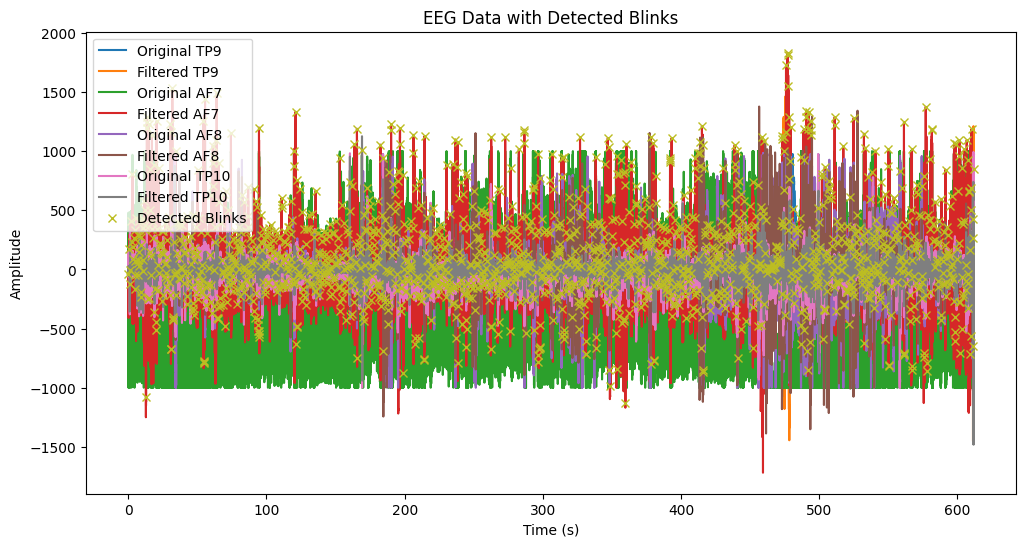

In [ ]:
# Bandpass Filter Function
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Removing Noise (0.5-30 Hz for EEG data)
fs = 256  # Sampling frequency (Hz)
filtered_data = {}
for column in ['TP9', 'AF7', 'AF8', 'TP10']:
    filtered_data[column] = bandpass_filter(data[column], 0.5, 30, fs)

# Detect peaks in all channels and find the common peaks (blinks)
peaks_dict = {}
for column in ['TP9', 'AF7', 'AF8', 'TP10']:
    peaks, _ = find_peaks(filtered_data[column], distance=fs*1.0, height=0.1)  # Adjusted interval to 1 second
    peaks_dict[column] = peaks

# Combine peaks from all channels
combined_peaks = np.unique(np.concatenate([peaks_dict[col] for col in peaks_dict]))

# Print the detected peaks for debugging
print("Detected peaks in all channels combined:", combined_peaks)

# Function to find blink sequences
def find_blink_sequence(peaks, min_blinks=3, max_blinks=5, expected_interval=1.0, tolerance=0.6):
    blink_intervals = np.diff(peaks) / fs  # Convert to seconds
    print("Blink intervals:", blink_intervals)

    # Filter peaks to those within the first 60 seconds
    peaks_first_60s = peaks[peaks < fs * 60]

    for num_blinks in range(max_blinks, min_blinks - 1, -1):
        for i in range(len(blink_intervals) - (num_blinks - 1)):
            if np.all(np.abs(blink_intervals[i:i+num_blinks-1] - expected_interval) < tolerance):
                blink_indices = peaks[i:i+num_blinks]
                # Ensure blink indices are within the first 60 seconds
                blink_indices_first_60s = blink_indices[blink_indices < fs * 60]
                if len(blink_indices_first_60s) >= min_blinks:
                    print(f"Found {len(blink_indices_first_60s)} blinks at indices {blink_indices_first_60s}")
                    return blink_indices_first_60s

    return []

# Find the blink sequence & Start of Activity
blink_indices = find_blink_sequence(combined_peaks)

# Print the found blink indices for debugging
print("Blink indices:", blink_indices)

# Determine the start and end indices for the experiment data
if blink_indices.any():
    start_index = blink_indices[-1] + fs  # 1 second after the last blink
    end_index = start_index + 600 * fs  # 600 seconds later

    # Extract the relevant segment
    experiment_data = data.iloc[start_index:end_index]

    # Save the extracted segment to a new CSV file in Google Drive
    experiment_data.to_csv('/content/drive/MyDrive/SRIP Project 8/EEG Data/4 July/Processed/Activity 3 Crossword Headset 2 - Processed (4 July).csv', index=False)


    # Compile timings of blinks in the first 60 seconds
    blink_times_first_60s = data['timestamps'][blink_indices]
    blink_times_first_60s.to_csv('blink_times_first_60s.csv', index=False)

    # Plot the original and filtered data with detected blinks
    plt.figure(figsize=(12, 6))
    for column in ['TP9', 'AF7', 'AF8', 'TP10']:
        plt.plot(data['timestamps'], data[column], label=f'Original {column}')
        plt.plot(data['timestamps'], filtered_data[column], label=f'Filtered {column}')
    plt.plot(data['timestamps'][combined_peaks], filtered_data['AF7'][combined_peaks], 'x', label='Detected Blinks')
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('EEG Data with Detected Blinks')
    plt.show()

    # Function to extract epochs (2-second epochs) - Use function below instead
    def extract_epochs(data, epoch_length=2, fs=256):
        epochs = []
        num_samples = epoch_length * fs
        for start in range(0, len(data), num_samples):
            end = start + num_samples
            if end <= len(data):
                epochs.append(data.iloc[start:end])
        return epochs
    #epochs = extract_epochs(experiment_data, epoch_length=2, fs=fs)

    # Save the epochs to separate CSV files - Not in Use
    #for i, epoch in enumerate(epochs):
        #epoch.to_csv(f'epoch_{i}.csv', index=False)
else:
    print("Unable to detect the blink sequence. Please check the data and parameters.")


In [ ]:
#data = df.to_numpy()
#data

array([[ 1.71886359e+09, -5.10254000e+02, -7.59277000e+02,
        -6.51367000e+02, -2.53906000e+02,  0.00000000e+00],
       [ 1.71886359e+09, -7.51950000e+01, -6.58691000e+02,
        -5.32227000e+02, -3.41800000e+01,  0.00000000e+00],
       [ 1.71886359e+09,  4.19434000e+02,  2.19238000e+02,
        -1.06934000e+02,  1.92383000e+02,  0.00000000e+00],
       ...,
       [ 1.71886428e+09, -9.61910000e+01, -4.39450000e+01,
        -4.09668000e+02, -5.46880000e+01,  0.00000000e+00],
       [ 1.71886428e+09,  3.51074000e+02,  9.91210000e+01,
         1.21094000e+02,  9.77000000e-01,  0.00000000e+00],
       [ 1.71886428e+09,  2.96387000e+02,  4.58980000e+01,
         2.55859000e+02,  1.46500000e+00,  0.00000000e+00]])

##Downsampling (Not in Use)

---



Length of TP9 data: 178488 samples
Length of processed TP9 data: 5577 samples
Total record time for TP9: 87.140625 seconds
 - Total 97 epochs were extracted for TP9, including the last epoch, which may have no enough data in it
 - 0 epochs were substituted/removed by previous ones because of the artifact
 - ID Lists of contaminated epochs are: []


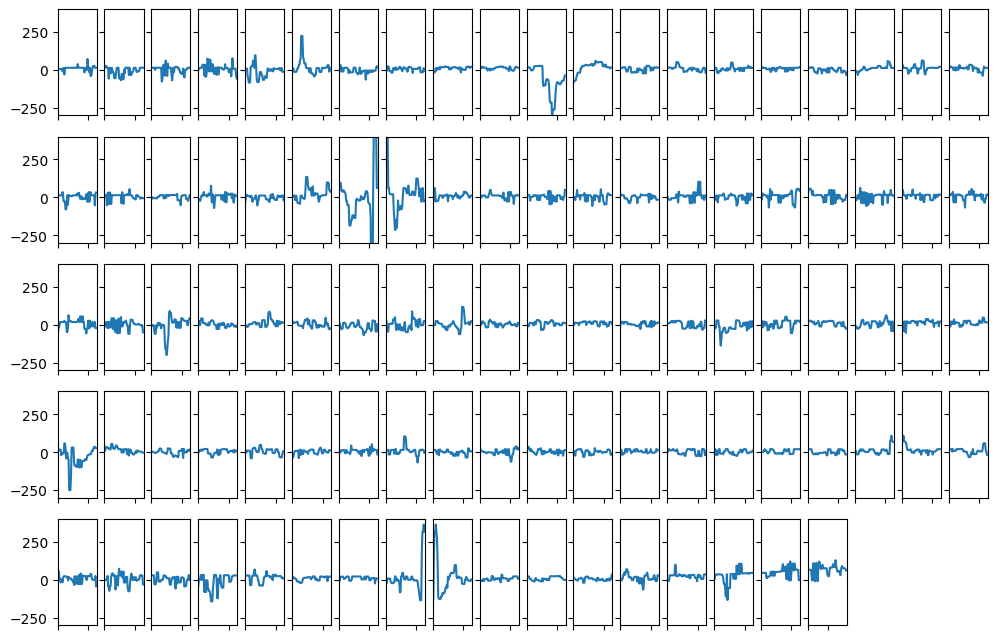

Length of AF7 data: 178488 samples
Length of processed AF7 data: 5577 samples
Total record time for AF7: 87.140625 seconds
 - Total 97 epochs were extracted for AF7, including the last epoch, which may have no enough data in it
 - 0 epochs were substituted/removed by previous ones because of the artifact
 - ID Lists of contaminated epochs are: []


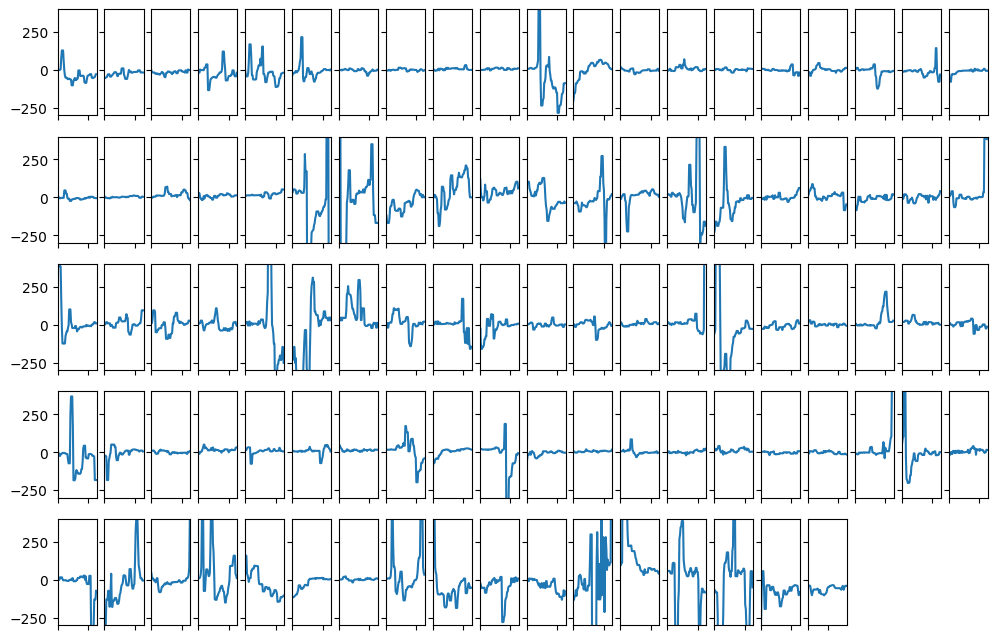

Length of AF8 data: 178488 samples
Length of processed AF8 data: 5577 samples
Total record time for AF8: 87.140625 seconds
 - Total 97 epochs were extracted for AF8, including the last epoch, which may have no enough data in it
 - 0 epochs were substituted/removed by previous ones because of the artifact
 - ID Lists of contaminated epochs are: []


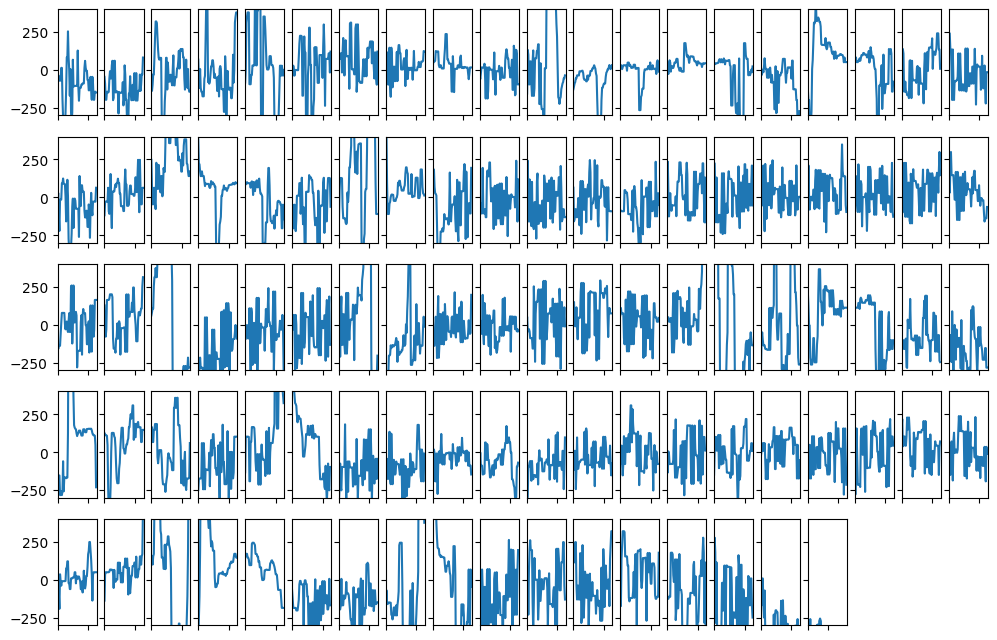

Length of TP10 data: 178488 samples
Length of processed TP10 data: 5577 samples
Total record time for TP10: 87.140625 seconds
 - Total 97 epochs were extracted for TP10, including the last epoch, which may have no enough data in it
 - 0 epochs were substituted/removed by previous ones because of the artifact
 - ID Lists of contaminated epochs are: []


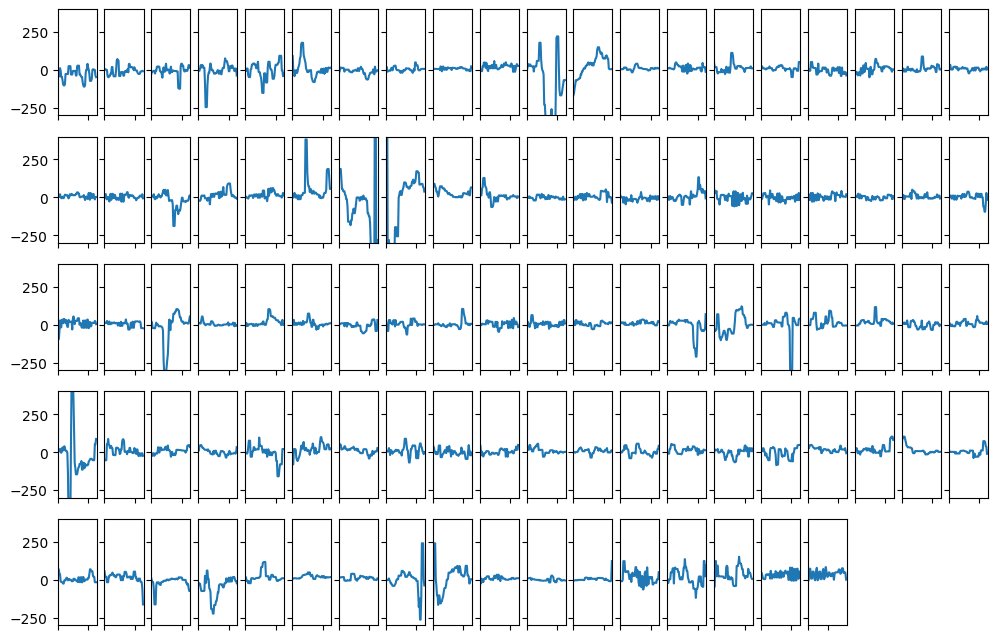

In [ ]:
def test_epochextract(df, epoch_duration=1, epoch_overlaptime=0.1, artifact_process_mode=0):
    columns_of_interest = ['TP9', 'AF7', 'AF8', 'TP10']
    for col_name in columns_of_interest:
        data = df[col_name].values
        print(f"Length of {col_name} data: {len(data)} samples")

        samplingrate_original = 2048
        samplingFrequency2Use = 64  # Downsample to 64 Hz
        data = calMultiSDW(data, samplingrate_original, samplingFrequency2Use)

        print(f"Length of processed {col_name} data: {len(data)} samples")
        total_record_time = len(data) / samplingFrequency2Use
        print(f"Total record time for {col_name}: {total_record_time} seconds")

        threshold = 140
        min_window_width = int(6 * samplingrate_original / samplingFrequency2Use)
        max_window_width = int(14 * samplingrate_original / samplingFrequency2Use)
        artifact_range, window_acc_v = eogdetection_accdiff(data, min_window_width, max_window_width, threshold)

        if artifact_process_mode == 0:
            epochs, nSubstituted, bSubstituted = epochextract(data, samplingFrequency2Use, epoch_duration, epoch_overlaptime, artifact_process_mode)
        else:
            epochs, nSubstituted, bSubstituted = epochextract(data, samplingFrequency2Use, epoch_duration, epoch_overlaptime, artifact_process_mode, artifact_range)

        nEpochs = len(epochs)
        print(f" - Total {nEpochs} epochs were extracted for {col_name}, including the last epoch, which may have no enough data in it")
        print(f" - {nSubstituted} epochs were substituted/removed by previous ones because of the artifact")
        print(f" - ID Lists of contaminated epochs are: {np.where(bSubstituted)[0]}")

        plt.figure(figsize=(12, 8))
        nPlotRow = 5
        nPlotColumn = (nEpochs + nPlotRow - 1) // nPlotRow
        for i, epoch in enumerate(epochs):
            plt.subplot(nPlotRow, nPlotColumn, i + 1)
            if epoch is None or len(epoch) == 0:
                plt.plot([0])
            elif bSubstituted[i]:
                plt.plot(epoch, color='r')
            else:
                plt.plot(epoch)
            if (i % nPlotColumn) != 0:
                plt.gca().set_yticklabels([])
            plt.gca().set_xticklabels([])
            if epoch is not None and len(epoch) > 0:
                plt.xlim([0, len(epoch)])
            plt.ylim([-300, 400])
        plt.show()

def calMultiSDW(sourcedata, samplingrate_original, samplingFrequency2Use, downsample=True):
    median_width = 5
    resamplingRate = samplingrate_original / samplingFrequency2Use
    order = 1
    cut_off_highpass_freq = 0.1

    b, a = butter(order, cut_off_highpass_freq / (samplingrate_original / 2), btype='high')
    tmp = filtfilt(b, a, sourcedata)

    if downsample:
        tmp = tmp[int(resamplingRate)::int(resamplingRate)]

    data = medfilt(tmp, median_width)
    return data

def epochextract(data, samplingrate, epoch_duration, epoch_overlaptime, artifact_process_mode, artifact_range=None):
    nRow = len(data)
    total_record_time = nRow / samplingrate
    nEpoch = int(np.ceil((total_record_time - epoch_overlaptime) / (epoch_duration - epoch_overlaptime)))
    epochs = [None] * nEpoch
    bSubstituted = np.zeros(nEpoch, dtype=bool)

    bArtifact = np.zeros(nRow, dtype=bool)
    if artifact_range is not None and artifact_process_mode != 0:
        for start, end in artifact_range:
            bArtifact[start:end + 1] = True

    nSubstituted = 0
    counter = 0
    for i in range(nEpoch):
        bArtifactFound = False
        starting_index = int((i * (epoch_duration - epoch_overlaptime) * samplingrate))
        ending_index = int(starting_index + epoch_duration * samplingrate - 1)
        if ending_index >= nRow:
            ending_index = nRow - 1

        if np.any(bArtifact[starting_index:ending_index + 1]):
            bArtifactFound = True

        if not bArtifactFound:
            epochs[i] = data[starting_index:ending_index + 1]
        elif i > 0 and epochs[i - 1] is not None:
            if artifact_process_mode == 1:
                epochs[i] = epochs[i - 1]
            else:
                epochs[i] = None
            bSubstituted[i] = True
            nSubstituted += 1
        else:
            counter += 1
            bSubstituted[i] = True
            nSubstituted += 1

    for i in range(counter):
        if artifact_process_mode == 1 and i > 0:
            epochs[i - 1] = epochs[i]

    return epochs, nSubstituted, bSubstituted

def eogdetection_accdiff(data, min_window_width, max_window_width, threshold):
    peaks, _ = find_peaks(data, height=threshold, distance=min_window_width)
    artifact_range = [(max(0, peak - min_window_width), min(len(data) - 1, peak + min_window_width)) for peak in peaks]
    window_acc_v = [data[start:end+1] for start, end in artifact_range]
    return artifact_range, window_acc_v

# Test function call
test_epochextract(df)


test_epochextract Function:

Loads data from a file.
Performs preprocessing (calMultiSDW function) to high-pass filter, downsample, and median filter the data.
Placeholder for EOG detection (eogdetection_accdiff function) to simulate artifact detection.
Epoch extraction (epochextract function) based on the specified parameters and artifact processing mode.
Prints information about extracted epochs and substituted/removed epochs due to artifacts.
Displays epochs in a subplot grid using Matplotlib.
calMultiSDW Function:

Performs high-pass filtering using butter and filtfilt.
Downsamples the data.
Applies median filtering to the downsampled data.
epochextract Function:

Calculates the number of epochs and initializes an array to store them.
Marks artifacts in the data based on the provided artifact range.
Iterates through potential epochs, checks for artifacts, and processes epochs based on the artifact processing mode.
Handles edge cases where artifacts span multiple epochs or where no valid epoch data exists.
eogdetection_accdiff Function:

Placeholder function for EOG detection. Currently returns empty lists for artifact ranges and window accuracy vectors.

##FFT

In [ ]:
# Load filtered data
filepath = '/content/drive/MyDrive/SRIP Project 8/EEG Data/4 July/Processed/Activity 3 Crossword Headset 3 - Processed (4 July).csv'
filtered_df = pd.read_csv(filepath, skiprows=0)
print("Columns in the DataFrame:", filtered_df.columns)

# Function to compute FFT and extract features
def compute_fft_features(data, fs):
    N = len(data)
    T = 1.0 / fs
    yf = fft(data)
    xf = np.fft.fftfreq(N, T)[:N//2]

    # Compute FFT magnitude
    fft_magnitude = 2.0/N * np.abs(yf[:N//2])

    # Extracting relevant features: mean, variance, power spectral density
    mean_val = np.mean(fft_magnitude)
    var_val = np.var(fft_magnitude)
    psd = np.sum(fft_magnitude ** 2) / len(fft_magnitude)

    # Define frequency bands
    delta = (0.5, 4)
    theta = (4, 8)
    alpha = (8, 13)
    beta = (13, 30)
    gamma = (30, 50)  # Adjust gamma band as needed

    # Find indices corresponding to frequency bands
    delta_idx = np.where((xf >= delta[0]) & (xf < delta[1]))[0]
    theta_idx = np.where((xf >= theta[0]) & (xf < theta[1]))[0]
    alpha_idx = np.where((xf >= alpha[0]) & (xf < alpha[1]))[0]
    beta_idx = np.where((xf >= beta[0]) & (xf < beta[1]))[0]
    gamma_idx = np.where((xf >= gamma[0]) & (xf < gamma[1]))[0]

    # Calculate band powers
    delta_power = np.sum(fft_magnitude[delta_idx])
    theta_power = np.sum(fft_magnitude[theta_idx])
    alpha_power = np.sum(fft_magnitude[alpha_idx])
    beta_power = np.sum(fft_magnitude[beta_idx])
    gamma_power = np.sum(fft_magnitude[gamma_idx])

    return mean_val, var_val, psd, delta_power, theta_power, alpha_power, beta_power, gamma_power

features = []

# Sampling frequency
fs = 256  # Hz

# Segment duration in seconds
segment_duration = 60  # seconds
samples_per_segment = segment_duration * fs

# Convert DataFrame columns to NumPy arrays
valid_columns = ['TP9', 'AF7', 'AF8', 'TP10']  # Adjust column names as needed
data_arrays = filtered_df[valid_columns].to_numpy()

# Iterate over each segment
segment_num = 0
for start in range(0, len(data_arrays), samples_per_segment):
    end = start + samples_per_segment
    segment_num += 1
    segment = data_arrays[start:end]

    # Compute FFT features for each channel
    segment_features = {'Segment': segment_num}  # Segment number starts from 1
    for i, column in enumerate(valid_columns):
        mean_val, var_val, psd, delta_power, theta_power, alpha_power, beta_power, gamma_power = compute_fft_features(segment[:, i], fs)

        # Store features for the current segment
        segment_features[f'{column}_mean_fft'] = mean_val
        segment_features[f'{column}_var_fft'] = var_val
        segment_features[f'{column}_psd'] = psd
        segment_features[f'{column}_delta_power'] = delta_power
        segment_features[f'{column}_theta_power'] = theta_power
        segment_features[f'{column}_alpha_power'] = alpha_power
        segment_features[f'{column}_beta_power'] = beta_power
        segment_features[f'{column}_gamma_power'] = gamma_power

    # Append features to the list
    features.append(segment_features)

# Convert features list to DataFrame
features_df = pd.DataFrame(features)
columns_order = ['Segment'] + [col for col in features_df.columns if col != 'Segment']
features_df = features_df[columns_order]

# Save to CSV
output_csv_path = '/content/drive/MyDrive/SRIP Project 8/EEG Data/4 July/FFT/Activity 3 Crossword Headset 3 - FFT with Bands and Segment (4 July).csv'
features_df.to_csv(output_csv_path, index=False)

print("Data exported successfully.")



Columns in the DataFrame: Index(['timestamps', 'TP9', 'AF7', 'AF8', 'TP10', 'Right AUX'], dtype='object')
Data exported successfully.


##Explanatory Data Analysis (Check for Missing Data)

In [ ]:
#!pip install --upgrade gspread pandas gspread_dataframe

from google.colab import auth
import gspread
from google.auth import default
from gspread_dataframe import get_as_dataframe

auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Loading Data (URL)
sheet_url = 'https://docs.google.com/spreadsheets/d/131m6aHg83ZqAvkHtQkARNGHYcJ8h2l7Tkc8idaHfj5U/edit#gid=0'
sheet = gc.open_by_url(sheet_url)
worksheet = sheet.get_worksheet(0)

# Convert to DataFrame
df = get_as_dataframe(worksheet)
df = df.dropna()
print(df.head())


   Segment/Minute  TP9_mean_fft  TP9_var_fft    TP9_psd  TP9_delta_power  \
0             1.0      0.870247     3.210132   3.967461      1416.379053   
1             2.0      0.894372     3.097549   3.897451      1658.425638   
2             3.0      0.643800     1.361592   1.776071       902.579167   
3             4.0      1.741092     8.357771  11.389173      2312.313888   
4             5.0      1.015192     6.049395   7.080010      1925.621167   

   TP9_theta_power  TP9_alpha_power  TP9_beta_power  TP9_gamma_power  \
0       852.253644       628.020820      781.912000       944.769509   
1       773.790817       720.042381      856.322884       964.676836   
2       480.374580       608.719528      665.504216       736.006820   
3      1969.318048      1445.025769     1930.159779      1967.210220   
4       654.699381       678.121047      970.589349      1078.808071   

   AF7_mean_fft  ...  TP10_psd  TP10_delta_power  TP10_theta_power  \
0      2.776191  ...  4.253542       156

In [ ]:
#Checking for Missing Data
df.isna().sum()

,0
Segment/Minute,0
TP9_mean_fft,0
TP9_var_fft,0
TP9_psd,0
TP9_delta_power,0
TP9_theta_power,0
TP9_alpha_power,0
TP9_beta_power,0
TP9_gamma_power,0
AF7_mean_fft,0


In [ ]:
#Checking for Duplicates
df.duplicated().sum()

0

In [ ]:
df.columns

Index(['Segment/Minute', 'TP9_mean_fft', 'TP9_var_fft', 'TP9_psd',
       'TP9_delta_power', 'TP9_theta_power', 'TP9_alpha_power',
       'TP9_beta_power', 'TP9_gamma_power', 'AF7_mean_fft', 'AF7_var_fft',
       'AF7_psd', 'AF7_delta_power', 'AF7_theta_power', 'AF7_alpha_power',
       'AF7_beta_power', 'AF7_gamma_power', 'AF8_mean_fft', 'AF8_var_fft',
       'AF8_psd', 'AF8_delta_power', 'AF8_theta_power', 'AF8_alpha_power',
       'AF8_beta_power', 'AF8_gamma_power', 'TP10_mean_fft', 'TP10_var_fft',
       'TP10_psd', 'TP10_delta_power', 'TP10_theta_power', 'TP10_alpha_power',
       'TP10_beta_power', 'TP10_gamma_power', 'Headset', 'Activity', 'Date',
       'Classification'],
      dtype='object')

In [ ]:
df = df.drop(columns = ['Activity', 'Date'])

In [ ]:
df

,Segment/Minute,TP9_mean_fft,TP9_var_fft,TP9_psd,TP9_delta_power,TP9_theta_power,TP9_alpha_power,TP9_beta_power,TP9_gamma_power,AF7_mean_fft,...,TP10_mean_fft,TP10_var_fft,TP10_psd,TP10_delta_power,TP10_theta_power,TP10_alpha_power,TP10_beta_power,TP10_gamma_power,Headset,Classification
0,1.0,0.870247,3.210132,3.967461,1416.379053,852.253644,628.020820,781.912000,944.769509,2.776191,...,0.655215,3.824236,4.253542,1563.262905,464.327256,294.365451,514.515817,574.140528,1.0,3.0
1,2.0,0.894372,3.097549,3.897451,1658.425638,773.790817,720.042381,856.322884,964.676836,2.909456,...,0.571884,1.949318,2.276369,1166.429140,381.993810,249.436726,485.813620,601.573681,1.0,3.0
2,3.0,0.643800,1.361592,1.776071,902.579167,480.374580,608.719528,665.504216,736.006820,2.476392,...,0.544347,2.094309,2.390623,1142.574403,448.531650,311.505076,482.926181,549.279379,1.0,3.0
3,4.0,1.741092,8.357771,11.389173,2312.313888,1969.318048,1445.025769,1930.159779,1967.210220,1.817895,...,0.741647,4.253510,4.803551,1783.363077,704.256300,493.610247,640.707734,562.537403,1.0,3.0
4,5.0,1.015192,6.049395,7.080010,1925.621167,654.699381,678.121047,970.589349,1078.808071,2.114131,...,0.453537,1.425369,1.631065,918.478922,428.761804,197.410524,395.506598,445.259177,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,6.0,2.039739,28.457486,32.618023,2261.732150,920.378493,577.077662,1162.509731,2257.161486,3.828507,...,2.302255,31.874964,37.175341,2708.627448,1025.306416,626.554923,1284.257148,2824.410912,3.0,3.0
328,7.0,5.023051,132.064676,157.295717,1860.851240,1906.988134,1250.327803,3125.118559,6082.034836,6.167274,...,4.945181,130.362826,154.817639,1554.851579,1849.297115,1249.698120,2999.513771,6196.804379,3.0,3.0
329,8.0,2.991461,43.070549,52.019389,2470.046641,1154.264260,661.557613,1597.481254,3713.187814,5.298676,...,3.149290,48.170730,58.088758,2981.516274,1299.801114,760.656931,1657.457835,3898.840732,3.0,3.0
330,9.0,5.057255,111.898656,137.474482,1491.879801,1980.585847,1219.838969,2980.218716,6125.063364,6.345931,...,5.129358,115.783879,142.094193,1871.606182,2057.199083,1226.654320,2964.984536,6191.930033,3.0,3.0


Continuous variables will be standardized.

##Distribution of Variables

In [ ]:
#Checking the Distribution of Social-Emotional Classes
df_count = df["Classification"].value_counts() / df["Classification"].value_counts().sum()
print(df_count)

Classification
2.0    0.622642
3.0    0.339623
1.0    0.037736
Name: count, dtype: float64


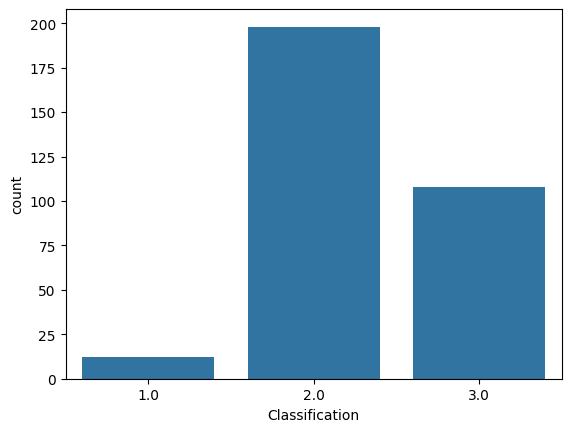

In [ ]:
# Data imbalance based on decision variable
sns.countplot(x=df["Classification"])
plt.show()

##Correlation of Variables

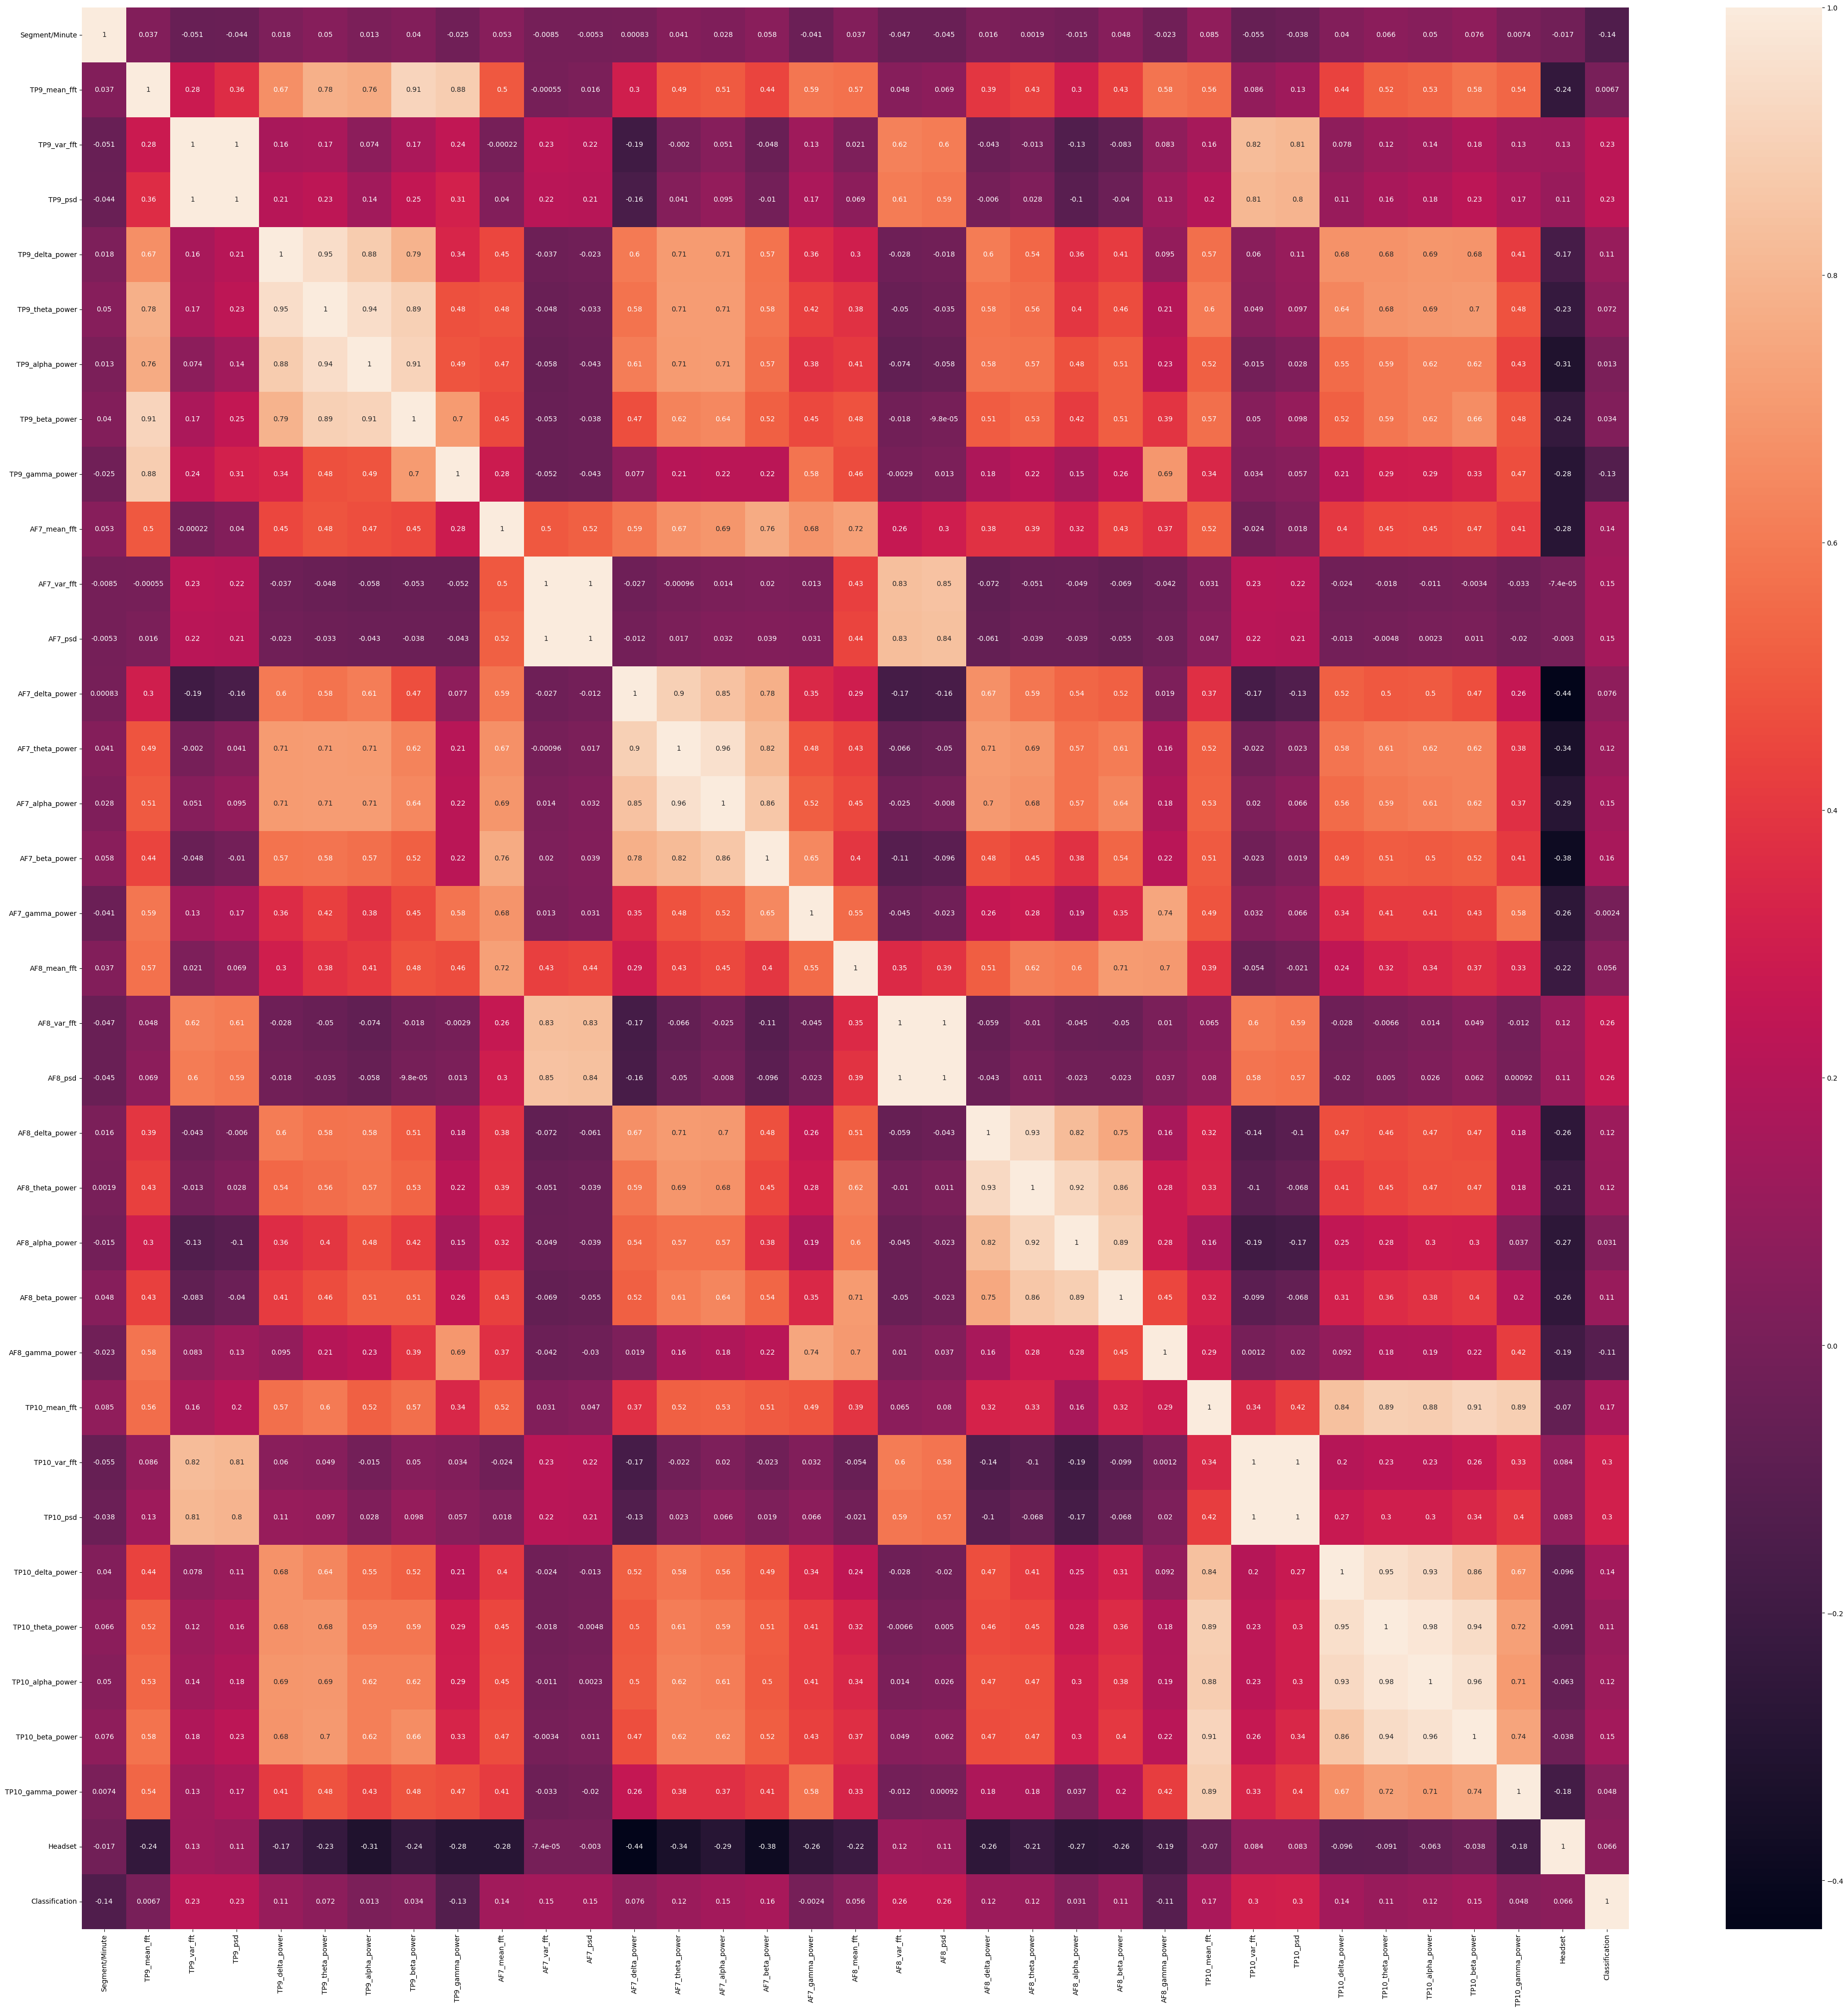

In [ ]:
corrMatrix = df.corr()
plt.figure(figsize=(50, 50))
sns.heatmap(corrMatrix, annot=True)
plt.show()
#include descriptions of the correlation

In [ ]:
print(corrMatrix[corrMatrix > 0.6])
#find the highly correlated variables

                  Segment/Minute  TP9_mean_fft  TP9_var_fft   TP9_psd  \
Segment/Minute               1.0           NaN          NaN       NaN   
TP9_mean_fft                 NaN      1.000000          NaN       NaN   
TP9_var_fft                  NaN           NaN     1.000000  0.995918   
TP9_psd                      NaN           NaN     0.995918  1.000000   
TP9_delta_power              NaN      0.666982          NaN       NaN   
TP9_theta_power              NaN      0.779380          NaN       NaN   
TP9_alpha_power              NaN      0.763096          NaN       NaN   
TP9_beta_power               NaN      0.910741          NaN       NaN   
TP9_gamma_power              NaN      0.883953          NaN       NaN   
AF7_mean_fft                 NaN           NaN          NaN       NaN   
AF7_var_fft                  NaN           NaN          NaN       NaN   
AF7_psd                      NaN           NaN          NaN       NaN   
AF7_delta_power              NaN           NaN     

##Feature Selection

Find the best variables correlated with output by setting a threshold of 0.5 for correlation coefficient absolute value with target

In [ ]:
# Get the absolute value of the correlation
cor_target = abs(corrMatrix['Classification'])
print(cor_target)

# Select highly correlated features (thresold = 0.5, 15 variables)
relevant_features = cor_target[cor_target > 0]
feature_list = [feature for feature, value in relevant_features.items()]
feature_list.remove('Classification')


print(feature_list)
print(len(feature_list))

Segment/Minute      0.138425
TP9_mean_fft        0.006722
TP9_var_fft         0.231172
TP9_psd             0.227247
TP9_delta_power     0.106978
TP9_theta_power     0.071773
TP9_alpha_power     0.012810
TP9_beta_power      0.034156
TP9_gamma_power     0.125425
AF7_mean_fft        0.139302
AF7_var_fft         0.147612
AF7_psd             0.148703
AF7_delta_power     0.076344
AF7_theta_power     0.115976
AF7_alpha_power     0.145811
AF7_beta_power      0.163136
AF7_gamma_power     0.002383
AF8_mean_fft        0.056462
AF8_var_fft         0.262657
AF8_psd             0.260068
AF8_delta_power     0.123768
AF8_theta_power     0.118261
AF8_alpha_power     0.030771
AF8_beta_power      0.109773
AF8_gamma_power     0.114700
TP10_mean_fft       0.168851
TP10_var_fft        0.300065
TP10_psd            0.304678
TP10_delta_power    0.144365
TP10_theta_power    0.110584
TP10_alpha_power    0.124033
TP10_beta_power     0.145450
TP10_gamma_power    0.047698
Headset             0.065986
Classification

## EDA Observations


No missing value
No duplicated data
The dataset is balanced/unbalanced.
Continuous variables are required to be standardized.
There are 34 variables and required feature selection to reduce number of features before model development
Select features which have a higher correlation with the target variable (diagnosis), set threshold of 0.5 as correlation coefficient. No variables are selected. RFE will be performed

## All Variables

## Data Preprocessing

In [ ]:
result = pd.concat([df[feature_list], df['Classification']], axis=1)
result

,Segment/Minute,TP9_mean_fft,TP9_var_fft,TP9_psd,TP9_delta_power,TP9_theta_power,TP9_alpha_power,TP9_beta_power,TP9_gamma_power,AF7_mean_fft,...,TP10_mean_fft,TP10_var_fft,TP10_psd,TP10_delta_power,TP10_theta_power,TP10_alpha_power,TP10_beta_power,TP10_gamma_power,Headset,Classification
0,1.0,0.870247,3.210132,3.967461,1416.379053,852.253644,628.020820,781.912000,944.769509,2.776191,...,0.655215,3.824236,4.253542,1563.262905,464.327256,294.365451,514.515817,574.140528,1.0,3.0
1,2.0,0.894372,3.097549,3.897451,1658.425638,773.790817,720.042381,856.322884,964.676836,2.909456,...,0.571884,1.949318,2.276369,1166.429140,381.993810,249.436726,485.813620,601.573681,1.0,3.0
2,3.0,0.643800,1.361592,1.776071,902.579167,480.374580,608.719528,665.504216,736.006820,2.476392,...,0.544347,2.094309,2.390623,1142.574403,448.531650,311.505076,482.926181,549.279379,1.0,3.0
3,4.0,1.741092,8.357771,11.389173,2312.313888,1969.318048,1445.025769,1930.159779,1967.210220,1.817895,...,0.741647,4.253510,4.803551,1783.363077,704.256300,493.610247,640.707734,562.537403,1.0,3.0
4,5.0,1.015192,6.049395,7.080010,1925.621167,654.699381,678.121047,970.589349,1078.808071,2.114131,...,0.453537,1.425369,1.631065,918.478922,428.761804,197.410524,395.506598,445.259177,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,6.0,2.039739,28.457486,32.618023,2261.732150,920.378493,577.077662,1162.509731,2257.161486,3.828507,...,2.302255,31.874964,37.175341,2708.627448,1025.306416,626.554923,1284.257148,2824.410912,3.0,3.0
328,7.0,5.023051,132.064676,157.295717,1860.851240,1906.988134,1250.327803,3125.118559,6082.034836,6.167274,...,4.945181,130.362826,154.817639,1554.851579,1849.297115,1249.698120,2999.513771,6196.804379,3.0,3.0
329,8.0,2.991461,43.070549,52.019389,2470.046641,1154.264260,661.557613,1597.481254,3713.187814,5.298676,...,3.149290,48.170730,58.088758,2981.516274,1299.801114,760.656931,1657.457835,3898.840732,3.0,3.0
330,9.0,5.057255,111.898656,137.474482,1491.879801,1980.585847,1219.838969,2980.218716,6125.063364,6.345931,...,5.129358,115.783879,142.094193,1871.606182,2057.199083,1226.654320,2964.984536,6191.930033,3.0,3.0


In [ ]:
sns.pairplot(result, hue = 'Classification')
plt.show()
sns.set(font_scale=1)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
X = df[feature_list]
y = df['Classification']
print(X)
print(y)

     Segment/Minute  TP9_mean_fft  TP9_var_fft     TP9_psd  TP9_delta_power  \
0               1.0      0.870247     3.210132    3.967461      1416.379053   
1               2.0      0.894372     3.097549    3.897451      1658.425638   
2               3.0      0.643800     1.361592    1.776071       902.579167   
3               4.0      1.741092     8.357771   11.389173      2312.313888   
4               5.0      1.015192     6.049395    7.080010      1925.621167   
..              ...           ...          ...         ...              ...   
327             6.0      2.039739    28.457486   32.618023      2261.732150   
328             7.0      5.023051   132.064676  157.295717      1860.851240   
329             8.0      2.991461    43.070549   52.019389      2470.046641   
330             9.0      5.057255   111.898656  137.474482      1491.879801   
331            10.0      5.923023    99.080628  134.162829      7224.647825   

     TP9_theta_power  TP9_alpha_power  TP9_beta_pow

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
model = RandomForestClassifier()

# Initialize RFE with the model
rfe = RFE(model, n_features_to_select=10)

# Fit RFE
fit = rfe.fit(X, y)

# Print the selected features
selected_features = [f for f, s in zip(df.columns, fit.support_) if s]
print("Selected Features: ", selected_features)


Selected Features:  ['TP9_theta_power', 'TP9_gamma_power', 'AF7_delta_power', 'AF7_gamma_power', 'AF8_var_fft', 'AF8_psd', 'AF8_theta_power', 'AF8_gamma_power', 'TP10_var_fft', 'Headset']


## RFE

In [ ]:
X = df[selected_features]
y = df['Classification']
print(X)
print(y)

     TP9_theta_power  TP9_gamma_power  AF7_delta_power  AF7_gamma_power  \
0         852.253644       944.769509      6176.063375      2207.017513   
1         773.790817       964.676836      5418.862333      2513.181237   
2         480.374580       736.006820      4561.572144      2227.209943   
3        1969.318048      1967.210220      3771.270999      1380.414176   
4         654.699381      1078.808071      3240.888094      1958.736705   
..               ...              ...              ...              ...   
327       920.378493      2257.161486      3169.039368      5576.948660   
328      1906.988134      6082.034836      2653.573827      6904.388643   
329      1154.264260      3713.187814      4378.617148      6292.433405   
330      1980.585847      6125.063364      2817.843884      6784.177274   
331      3561.688501      4831.521080      7655.836691      6106.994399   

     AF8_var_fft     AF8_psd  AF8_theta_power  AF8_gamma_power  TP10_var_fft  \
0      29.669384   

## Train-Test Splitting

In [ ]:
#train test data split and standardise data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

#create an instance of standard scaler
scaler = StandardScaler()
scaler.fit(X_train)

#transform training data and testing data
scaler.transform(X_train)
scaler.transform(X_test)

array([[-4.19615576e-01, -2.30203302e-01, -1.25378301e+00,
        -1.06227373e+00, -2.90993003e-01, -2.75749468e-01,
         5.63098471e-01,  1.51662684e-01, -4.58296196e-01,
        -9.83207022e-01],
       [-1.17684665e+00, -8.89539851e-01, -1.59336570e+00,
        -1.23213090e+00,  3.46729653e+00,  3.38973719e+00,
        -1.02946009e+00, -9.92784322e-01,  3.20660766e+00,
         8.87464016e-01],
       [-4.63099856e-01, -6.89637079e-01,  5.60065085e-01,
        -7.50740649e-01,  2.69452458e-02,  5.84447413e-02,
         1.77736942e+00, -3.24186353e-01, -6.37361137e-01,
        -9.83207022e-01],
       [-6.19022089e-01, -8.17266982e-01, -1.16902110e+00,
        -1.08498750e+00,  3.46756193e+00,  3.39396173e+00,
        -5.61201751e-01, -1.02579034e+00,  3.23758550e+00,
         8.87464016e-01],
       [-4.99785157e-01, -7.88862140e-01, -7.94604956e-01,
        -1.08856835e+00,  3.52939564e+00,  3.45772398e+00,
        -4.73577020e-01, -9.74394506e-01,  3.23769096e+00,
         8.

# K-Nearest Neighbour (KNN)

In [ ]:

model = KNeighborsClassifier()

# model fitting
model.fit(X_train, y_train)

# predict using the model
pred = model.predict(X_test)

# model validation
print('accuracy score (before tuning):' ,accuracy_score(pred, y_test))
print(confusion_matrix(pred, y_test))
print(pred.max())
print(classification_report(pred, y_test))

accuracy score (before tuning): 0.65625
[[ 1  0  0]
 [ 3 29 14]
 [ 0  5 12]]
3.0
              precision    recall  f1-score   support

         1.0       0.25      1.00      0.40         1
         2.0       0.85      0.63      0.72        46
         3.0       0.46      0.71      0.56        17

    accuracy                           0.66        64
   macro avg       0.52      0.78      0.56        64
weighted avg       0.74      0.66      0.68        64



## Hyperparameter Tuning & Cross-Validation

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = [{'n_neighbors': list(range(1,34)), 'weights': ['uniform', 'distance'],
                'p': [1,2]}]
from sklearn.metrics import f1_score, accuracy_score, classification_report

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model,
                           param_grid=parameters,
                           scoring='accuracy',
                           cv=5)

knnmodel = grid_search.fit(X_train, y_train)
predknn = knnmodel.predict(X_test)
best_parameters = grid_search.best_params_

# f1 score for multiclass classification
f1 = f1_score(y_test, predknn, average='weighted')

print('Best parameters:', best_parameters)
print('F1 score:', f1)
# Model validation
print('Accuracy score (after tuning):', accuracy_score(y_test, predknn))
print('Classification report:\n', classification_report(y_test, predknn))


Best parameters: {'n_neighbors': 17, 'p': 1, 'weights': 'distance'}
F1 score: 0.6362058080808081
Accuracy score (after tuning): 0.6875
Classification report:
               precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         4
         2.0       0.63      1.00      0.77        34
         3.0       1.00      0.38      0.56        26

    accuracy                           0.69        64
   macro avg       0.54      0.46      0.44        64
weighted avg       0.74      0.69      0.64        64



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Explanation:

**Best Parameters**

n_neighbours: 16 nearest neighbours
p: 1 (Manhattan Distance)
weights: 'distance' - weighting scheme where closer neighbors have more influence.


The overall F1 score for the model is 0.6362. This is a weighted average of the F1 scores for each class, accounting for the support (number of true instances) of each class.

The overall accuracy of the model is 0.6875 or about 68.75%. This means that the model correctly predicted the class for approximately 68.75% of the samples in the test set.

**Classification Report**

The classification report provides detailed metrics for each class:

**Class 1.0**
Precision: 0.00
Out of all instances predicted as class 1.0, 0% were correct.
Recall: 0.00
Out of all true instances of class 1.0, 0% were correctly predicted.
F1-Score: 0.00
The harmonic mean of precision and recall, which is 0 due to both being 0.
Support: 4
The number of true instances of class 1.0 in the test set is 4.

**Class 2.0**
Precision: 0.63
Out of all instances predicted as class 2.0, 62% were correct.
Recall: 1.00
Out of all true instances of class 2.0, 100% were correctly predicted.
F1-Score: 0.77
The harmonic mean of precision and recall.
Support: 34
The number of true instances of class 2.0 in the test set is 34.

**Class 3.0**
Precision: 1.00
Out of all instances predicted as class 3.0, 100% were correct.
Recall: 0.38
Out of all true instances of class 3.0, 35% were correctly predicted.
F1-Score: 0.56
The harmonic mean of precision and recall.
Support: 26
The number of true instances of class 3.0 in the test set is 26.

**Macro and Weighted Averages**

Macro Avg: The unweighted average of precision, recall, and F1-score across all classes. It treats all classes equally.
Precision: 0.54
Recall: 0.46
F1-Score: 0.44

Weighted Avg: The weighted average of precision, recall, and F1-score, taking into account the number of instances in each class.
Precision: 0.74
Recall: 0.69
F1-Score: 0.64

**Interpretation**

The model performs very well for class 2.0, with high recall (1.00) and a decent precision (0.63), leading to a good F1-score (0.77).
The model struggles with class 1.0, failing to correctly predict any instances of this class, resulting in 0 precision, recall, and F1-score.
For class 3.0, the model has perfect precision (1.00), meaning it makes no false positive predictions for this class, but the recall is low (0.38), indicating many instances of this class are missed.

**Summary**

The model has good accuracy overall, but the performance is uneven across classes. It performs well for class 2.0 but poorly for class 1.0 and class 3.0. The weighted average F1-score reflects the model's performance across all classes, considering the imbalance in the number of instances per class.

##KNN Confusion Matrix

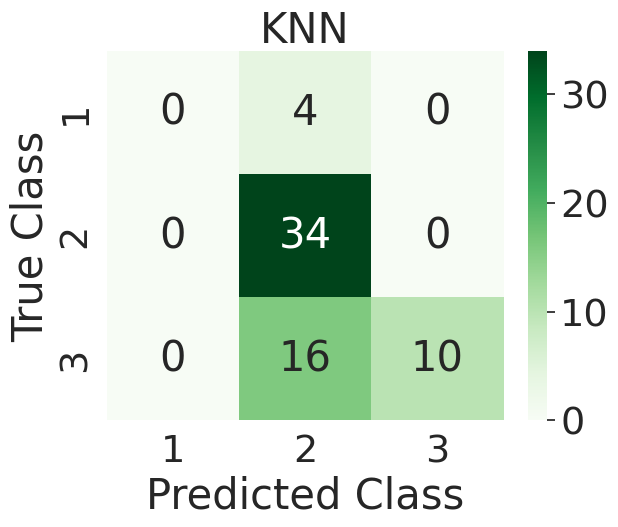

In [ ]:
ax= plt.subplot()
cm = confusion_matrix(y_test, predknn)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = 'Greens')
#annot=True to annotate cells, ftm='g' to disable scientific notation
ax.set_xlabel('Predicted Class');ax.set_ylabel('True Class');
ax.set_title('KNN');
ax.xaxis.set_ticklabels(['1', '2', '3']); ax.yaxis.set_ticklabels(['1', '2', '3']);
sns.set(font_scale=2.5)

Analysis:

All of Class 1 readings are predicted as Class 2.

61.5% of Class 3 are predicted as Class 2.

All of Class 2 are predicted correctly.

The ML is more skewed towards Class 2 due to its highly imbalanced distribution of classes.

# Support Vector Machine

In [ ]:
#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [ ]:
# Calculate and print accuracy, precision, and recall
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='weighted')
recall = metrics.recall_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.609375
Precision: 0.6675310283687943
Recall: 0.609375


## Hyperparameter Tuning & Cross-Validation

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf']
}

# Create a GridSearchCV object
grid = GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=2, cv=5)

# Fit the grid search to the data
grid.fit(X_train, y_train)

# Get the best parameters
best_params = grid.best_params_
print("Best parameters found: ", best_params)

# Predict using the best estimator
y_pred = grid.predict(X_test)

# Evaluate the model
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='weighted')
recall = metrics.recall_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time= 1.5min
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=  53.1s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time= 1.4min
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time= 1.3min
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time= 1.3min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time= 1.4min
[CV] END ...................C=0.1, gamma=0.01, k

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Confusion Matrix

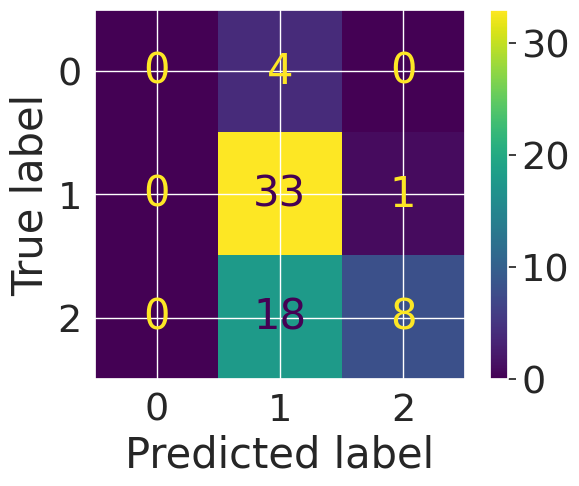

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


## Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVM with scaled features
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

# Evaluate the model
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='weighted')
recall = metrics.recall_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


Accuracy: 0.625
Precision: 0.7176724137931034
Recall: 0.625


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
